In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
def gini_index(y):
    if isinstance(y, pd.Series):
        a = y.value_counts()/y.shape[0]
        gini = 1 - np.sum(a**2)
        return gini
    else:
        raise ValueError('Object must be a Pandas Series.')

gini_index(df.male)

0.4899780876454096

In [7]:
def entropy(y):
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)
  else:
    raise('Object must be a Pandas Series.')

entropy(df.male)

0.985492741578452

In [8]:
def variance(y):
  if(len(y) == 1):
    return 0
  else:
    return y.var()

In [12]:
def information_gain(y, mask, func=gini_index):
    a = sum(mask)
    b = mask.shape[0] - a

    if a == 0 or b == 0:
        gain = 0
    else:
        gain = func(y) - (a/(a+b) * func(y[mask])) - (b/(a+b) * func(y[~mask]))

    return gain

In [13]:
information_gain(df['TenYearCHD'], df['male'] == 1,entropy)

0.005584268669201697

In [14]:
information_gain(df['TenYearCHD'], df['male'] == 1,gini_index)

0.002015335645880023

In [15]:
def categorical_options(a):
    a = a.unique()
    opciones = [list(subset) for L in range(0, len(a)+1) for subset in itertools.combinations(a, L)]
    return opciones[1:-1]

In [22]:
def max_information_gain_split(x, y, func=gini_index):
    split_value = []
    gain = []
    numeric_variable = True if x.dtypes != 'O' else False
    options = x.sort_values().unique()[1:] if numeric_variable else categorical_options(x)

    for val in options:
        mask = x < val if numeric_variable else x.isin(val)
        val_gain = information_gain(y, mask, func)
        gain.append(val_gain)
        split_value.append(val)

    if len(gain) == 0:
        return None, None, None, False
    else:
        best_gain = max(gain)
        best_gain_index = gain.index(best_gain)
        best_split = split_value[best_gain_index]
        return best_gain, best_split, numeric_variable, True

In [23]:
df.drop('TenYearCHD', axis= 1).apply(max_information_gain_split, y = df['TenYearCHD'])

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0.002015,0.010096,0.001754,0.000098,0.00069,0.001753,0.000985,0.00813,0.002441,0.001642,0.008703,0.005419,0.002012,0.000594,0.00076
1,1,49,2.0,1,15.0,1.0,1,1,1,257.0,138.0,88.0,27.88,90.0,91.0
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [26]:
def get_best_split(y, dataset):
  masks = dataset.drop(y, axis= 1).apply(max_information_gain_split, y = dataset[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_gain, split_numeric)


def make_split(variable, value, dataset, is_numeric):
  if is_numeric:
    dataset_1 = dataset[dataset[variable] < value]
    dataset_2 = dataset[(dataset[variable] < value) == False]
  else:
    dataset_1 = dataset[dataset[variable].isin(value)]
    dataset_2 = dataset[(dataset[variable].isin(value)) == False]

  return(dataset_1,dataset_2)


def make_prediction(dataset, target_factor):
  if target_factor:
    pred = dataset.value_counts().idxmax()
  else:
    pred = dataset.mean()

  return pred

In [27]:
def train_tree(dataset,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):

  if counter==0:
    types = dataset.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(dataset[column].value_counts())
      if var_length > max_categories:
        raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  if min_samples_split == None:
    sample_cond = True

  else:
    if dataset.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  if depth_cond & sample_cond:
    var,val,gain,var_type = get_best_split(y, dataset)

    if gain is not None and gain >= min_information_gain:
      counter += 1
      left,right = make_split(var, val, dataset,var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
      subtree = {question: []}

      # Find answers (recursion)
      yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    else:
      pred = make_prediction(dataset[y],target_factor)
      return pred

  else:
    pred = make_prediction(dataset[y],target_factor)
    return pred

  return subtree

max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5

decision = train_tree(df,'TenYearCHD',True, max_depth,min_samples_split,min_information_gain)

decision

{'age <=  49': [{'sysBP <=  192.5': [{'cigsPerDay <=  17.0': [0,
      {'sysBP <=  133.0': [0, {'BMI <=  21.48': [1, 0]}]}]},
    1]},
  {'sysBP <=  155.5': [{'age <=  65': [{'BMI <=  41.61': [0, 1]},
      {'prevalentStroke <=  1': [{'totChol <=  177.0': [1, 0]}, 1]}]},
    {'male <=  1': [{'sysBP <=  193.0': [{'diaBP <=  74.0': [1, 0]},
        {'age <=  62': [0, 1]}]},
      {'totChol <=  201.0': [{'BMI <=  24.9': [1, 0]},
        {'glucose <=  72.0': [0, 1]}]}]}]}]}

Implementing SciKit Learn Decision Tree and Plotting it

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['TenYearCHD']), df['TenYearCHD'], test_size=0.2, random_state=42)

In [31]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=42)

In [32]:
y_pred = clf.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn Decision Tree Accuracy: {sklearn_accuracy}")

Scikit-learn Decision Tree Accuracy: 0.8419811320754716


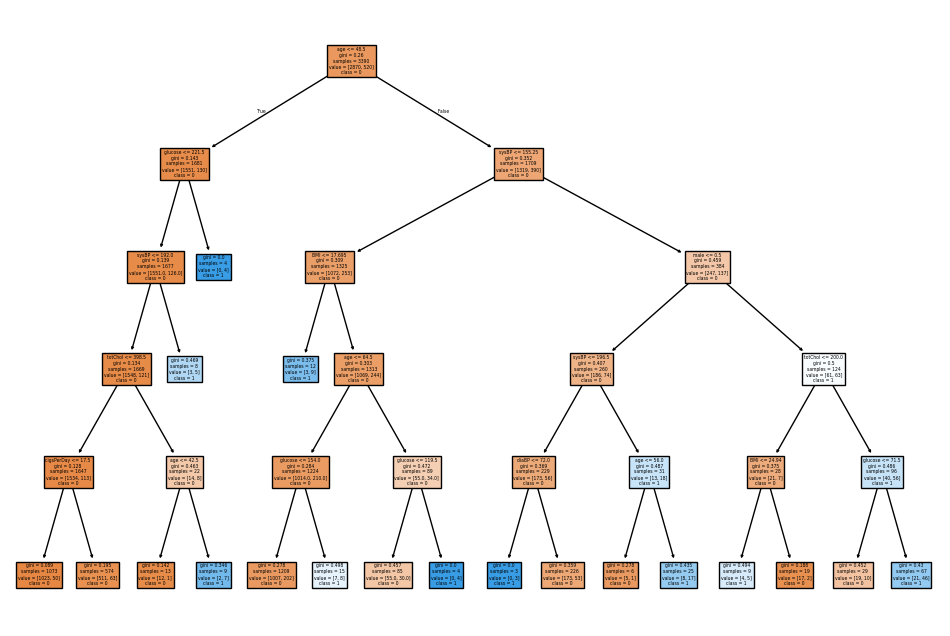

In [33]:
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df.columns[:-1], class_names=[str(i) for i in set(y_train)], filled=True)
plt.show()
